In [1]:
# Purpose: Quickly analysing ENSOWind EXP to see if all okay
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m


#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Loading in 025deg_jra55_iaf data and calculating N34 index

CPU times: user 44.7 s, sys: 2.37 s, total: 47.1 s
Wall time: 42.9 s


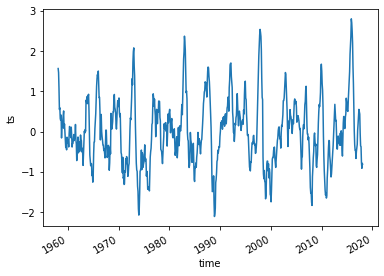

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
version = 'v20180412' #'v20190429'                                                                             #
short = 'gn' # 'gr'                                                                                            #
# ------------------------------------------------------------------------------------------------------------ #

out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'

# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) 
N34_JRA = ts.isel(lat=slice(150,170)).isel(lon = slice(338,428)).mean(['lat','lon']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E
N34_JRA.plot()
# Wall time: 51.4 s

### Ok, next step is getting the temperature in the Amundsen Sea just like in Paul's plot

CPU times: user 26 s, sys: 2.13 s, total: 28.2 s
Wall time: 31.4 s


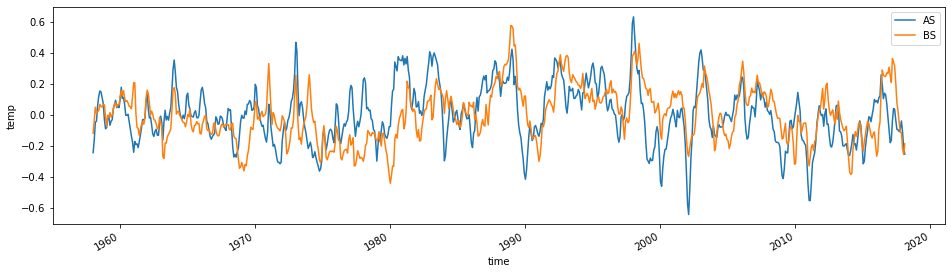

In [66]:
%%time
base_omip = '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle'
# select Amundsen Sea 90°S-60°S, 160°W-60°W and down to 1000 m depth -> .temp.isel(yt_ocean=slice(0,196)).isel(xt_ocean=slice(479,880))
# select Amundsen Sea 90°S-70°S, 130°W-110°W and down to 1000 m depth -> .temp.isel(yt_ocean=slice(0,105)).isel(xt_ocean=slice(479,880))

# select Amundsen Sea 90°S-58°S, 130°W-110°W and down to 1000 m depth -> isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(599,680)).isel(st_ocean=slice(0,29)) 
# select Amundsen Sea 90°S-70°S, 127°W-101°W and down to 1000 m depth -> isel(yt_ocean=slice(0,105)).isel(xt_ocean=slice(611,720)).isel(st_ocean=slice(0,29))
for f in range(2):
    if f == 0: # Amundsen Sea sector, 127°E-101°E, 90°S-58°S, 1000 m
        temp = xr.open_mfdataset(base_omip + '6/output*/ocean/ocean_month.nc').temp.isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(599,680)).isel(st_ocean=slice(0,29))
        AS_eckdaten = [90, 58, 127, 101]
    if f == 1: # Bellingshausen Sea sector, 110°E-80°E, 90°S-58°S, 1000 m
        temp = xr.open_mfdataset(base_omip + '6/output*/ocean/ocean_month.nc').temp.isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(680,800)).isel(st_ocean=slice(0,29)) 

    anom = temp.groupby('time.month') - temp.groupby('time.month').mean('time')
    anom = anom.mean(['st_ocean','yt_ocean','xt_ocean'])[:-10].load()
    if f == 0:
        temp_A = anom
    if f == 1:
        temp_B = anom
plt.figure(figsize=(16,4)); # N34_JRA.plot(label='N34', c='k')
temp_A.plot(label='AS'); temp_B.plot(label='BS'); plt.legend()
# Walltime: 32.6 s

### Getting the same temperature in the 01° model

In [4]:
# %%time
# import cosima_cookbook as cc
# session = cc.database.create_session()
# # cc.querying.get_experiments(session,'01deg_jra55v140_iaf_cycle3')

# #                                                   experiment,           variable, session
# OHC_01deg_c3 = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/'+'01deg_jra55v140_iaf_cycle3/output*/ocean/ocean-3d-temp*.nc').temp
# # select Amundsen Sea sector(81.11°S - 60°S, 130°W - 110°W and upper 1000 m)
# temp = OHC_01deg_c3.isel(yt_ocean=slice(0,491)).isel(xt_ocean=slice(1500,1701)).isel(st_ocean=slice(0,47))

# anom = temp.groupby('time.month') - temp.groupby('time.month').mean('time')
# temp_A01 = anom.mean(['st_ocean','yt_ocean','xt_ocean'])[:-10].load()


# # Warnings here because memory budget exceeds

### Plotting routine

CPU times: user 1.05 s, sys: 119 ms, total: 1.17 s
Wall time: 1.05 s


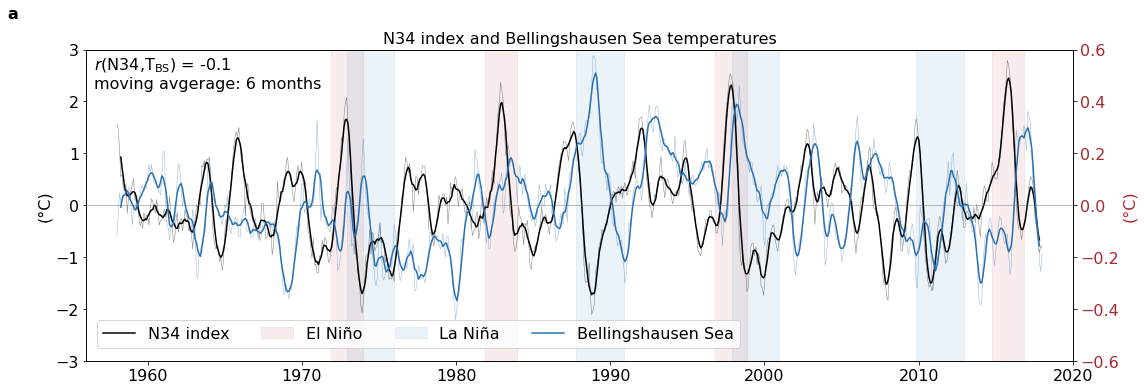

In [72]:
%%time
# def moving_average(x, w): # x = time series, w = window
#     return np.convolve(x, np.ones(w), 'valid') / w

a = N34_JRA; b = temp_A; c = temp_B
event = ['El Niño', 'La Niña']
for f in [4]:#range(4):
    if f == 0:
        window = 0
        filename = 'JRA55-do_N34_and_ACCESSOM2_Amundsen_temp_timeseries'
    if f == 1:
        window = 6 # rolling mean with a window of 6 months
        filename = 'JRA55-do_N34_and_ACCESSOM2_Amundsen_temp_timeseries_filtered_'+str(window)
    if f == 2:
        window = 12
        filename = 'JRA55-do_N34_and_ACCESSOM2_Amundsen_temp_timeseries_filtered_'+str(window)
    if f == 3:
        window = 18
        filename = 'JRA55-do_N34_and_ACCESSOM2_Amundsen_temp_timeseries_filtered_'+str(window)        
    if f == 4:
        window = 6
        filename = 'JRA55-do_N34_and_ACCESSOM2_Amundsen_temp_timeseries_filtered_'+str(window)+'_AS-only'     
        
    time = np.linspace(1958,2018,len(N34_JRA)) # I cannot use the .time attribute from the xarray array as using it does not work with ax1.axvspan()
    fig, ax1 = plt.subplots(figsize=(16,10),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2, 2)
    
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- - #
# --- Panel (a) with N34 and simulated Amundsen Sea Sector tempeature anomalies --- #
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- - #

    ax1 = plt.subplot(gs[0,:])
    ax1.set_ylabel('(°C)', color='k', fontsize=16)  # we already handled the x-label with ax1
    if f == 4:
        ax1.plot(time, a, c='k', linewidth=.5, alpha=.5) # grey original N34 data  
        ax1.plot(time, a.rolling(time=window, center=True).mean(), c='k', label='N34 index', linewidth=1.5) # plot the data
                                       # 'N34$_\mathrm{{ (5°S-5°N, 170°W-120°W)}}$'

    ax1.axhline(0, linewidth=.5, c='grey')

    # plot the four extreme EN event periods
    ax1.axvspan(time[167], time[192], color=rotblau[4], alpha=.1); ax1.axvspan(time[287], time[312], color=rotblau[4], alpha=.1)
    ax1.axvspan(time[466], time[491], color=rotblau[4], alpha=.1); ax1.axvspan(time[682], time[707], color=rotblau[4], alpha=.1, label='El Niño')
    # plot the four extreme LN event periods
    ax1.axvspan(time[179], time[216], color=rotblau[16], alpha=.1); ax1.axvspan(time[358], time[395], color=rotblau[16], alpha=.1)
    ax1.axvspan(time[479], time[516], color=rotblau[16], alpha=.1); ax1.axvspan(time[623], time[660], color=rotblau[16], alpha=.1, label='La Niña')

    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.ylim([-3,3])

    # ---- second y-axis
    # ------------------
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    ax2.set_ylabel('(°C)', color=rotblau[3], fontsize=16)  # we already handled the x-label with ax1
    if f == 4:
        # ax2.plot(time, temp_A, c=rotblau[3], linewidth=.5, alpha=.5) # light red original data  
        # ax2.plot(time, b.rolling(time=window, center=True).mean(), c=rotblau[3], label='Amundsen Sea', linewidth=1.5) # plot the data

        ax2.plot(time, temp_B, c=rotblau[17], linewidth=.5, alpha=.5) # light red original data  
        ax2.plot(time, c.rolling(time=window, center=True).mean(), c=rotblau[17], label='Bellingshausen Sea', linewidth=1.5) # plot the data

    ax2.tick_params(axis='y', labelcolor=rotblau[3])
    plt.ylim([-.6,.6])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.xlim([1956,2020])
    fig.legend(fontsize=16, ncol=5, bbox_to_anchor=(.08, .5), loc='lower left')

    if f in [0,1,2,3]:
        plt.text(1956.5,.45,'$\it{r}$(N34,T$_{\mathrm{AS}}$) = '+str(np.round(np.corrcoef(a,b)[0,1],2))+
                 '$, \it{r}$(N34,T$_{\mathrm{BS}}$) = '+str(np.round(np.corrcoef(a,c)[0,1],2))+
                 '\nmoving avgerage: '+str(window)+ ' months',fontsize=16) # correlation coefficient
    if f == 4:
        plt.text(1956.5,.45,'$\it{r}$(N34,T$_{\mathrm{BS}}$) = '+str(np.round(np.corrcoef(a,c)[0,1],2))+
                 '\nmoving avgerage: '+str(window)+ ' months',fontsize=16) # correlation coefficient
    ax1.text(-.08, 1.1,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.title('N34 index and Bellingshausen Sea temperatures', fontsize=16)
    # Wall time: 45.7 s 
    
# # --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- #
# # --- Panels (b) and (c), composite and idealised time series --- --- --- --- --- #
# # --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- #
#     if f == 4:
#         time = np.linspace(1,24,24) # time axis of idealised time series
#         time2 = np.linspace(1,24+12,24+12) # time axis of idealised time series

#         # top four El Niño events
#         EN_periods = [168,192,288,312,467,491,683,707]
#         N34_1972 = N34_JRA.isel(time = slice(EN_periods[0],EN_periods[1])).load() # N34 peak in 1972-12 (index 180)
#         N34_1982 = N34_JRA.isel(time = slice(EN_periods[2],EN_periods[3])).load() # N34 peak in 1982-12 (index 300)
#         N34_1997 = N34_JRA.isel(time = slice(EN_periods[4],EN_periods[5])).load() # N34 peak in 1997-11 (index 479)
#         N34_2015 = N34_JRA.isel(time = slice(EN_periods[6],EN_periods[7])).load() # N34 peak in 2015-12 (index 695)
#         # top four La Niña events
#         LN_periods = [180,216,359,395,480,516,624,660]
#         N34_1973 = N34_JRA.isel(time = slice(LN_periods[0],LN_periods[1])).load() # N34 peak in 1972-12 (index 192)
#         N34_1988 = N34_JRA.isel(time = slice(LN_periods[2],LN_periods[3])).load() # N34 peak in 1984-12 (index 370)
#         N34_1998 = N34_JRA.isel(time = slice(LN_periods[4],LN_periods[5])).load() # N34 peak in 1997-11 (index 491)
#         N34_2011 = N34_JRA.isel(time = slice(LN_periods[6],LN_periods[7])).load() # N34 peak in 2015-12 (index 634)

# ---------------------------- subplot b and c ---------------------------- #
# for f in range(2):
#     ax1 = plt.subplot(gs[1,f]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
#     plt.axhline(0, c = 'grey', linewidth=.5)

#     if f == 0:
#         plt.plot(time, N34_1972, label = '1972/73', color=rotblau[7])
#         plt.plot(time, N34_1982, label = '1982/83', color=rotblau[5])
#         plt.plot(time, N34_1997, label = '1997/98', color=rotblau[3])
#         plt.plot(time, N34_2015, label = '2015/16', color=rotblau[1])
#     if f == 1:
#         plt.plot(time2, N34_1973, label = '1973/43', color=rotblau[13])
#         plt.plot(time2, N34_1988, label = '1988/87', color=rotblau[15])
#         plt.plot(time2, N34_1998, label = '1998/99', color=rotblau[17])
#         plt.plot(time2, N34_2011, label = '2011/12', color=rotblau[20])
  
#     EN_mean = np.zeros(24); LN_mean = np.zeros(24+12)
#     for i in range(24):
#         EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
#     for i in range(24+12):
#         LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
#     if f == 0:
#         plt.plot(time, EN_mean, label = 'N34 mean', c = 'k', linestyle = '--', linewidth=3)
#         poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
#         N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
#         plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
#         ax1.axvspan(time[6], time[18], color=rotblau[4], alpha=.1) # shade period July to June the following year
#     if f == 1:
#         plt.plot(time2, LN_mean, label = 'N34 mean', c = 'k', linestyle = '--', linewidth=3)
#         poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
#         N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
#         plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
#         ax1.axvspan(time[6], time[18], color=rotblau[16], alpha=.1)     

#     plt.legend(fontsize=16, ncol=2); plt.title('Composite of centered '+event[f]+' events', fontsize=16)
#     ax1.set_xlabel('Month', fontsize=16)
#     if f == 0: ax1.set_ylabel('N34 (°C)', fontsize=16)
#     # set fontsizes and labels
#     plt.xticks(fontsize=16); plt.yticks(fontsize=16)
#     if f == 1: ax1.set_yticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
#     ax1.text(-.08, 1.1,string.ascii_lowercase[f+1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
#     plt.ylim([-2.2,3])
# --- saving as 300 dpi .PNG image in specified folder ------------- #
plt.savefig(save + filename, dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 1.98 s

### Quick plot Amundsen sea region

CPU times: user 1.1 s, sys: 146 ms, total: 1.24 s
Wall time: 1.15 s


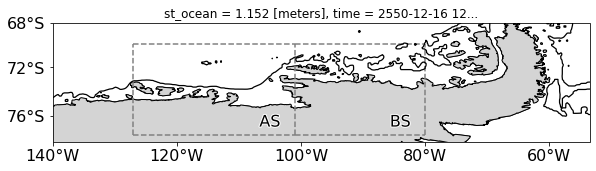

In [39]:
%%time

def fancy_plot(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([-140,-120,-100,-80, -60], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-76, -72, -68], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    # Amundsen and Bellingshausen Sea regions
    AS = [-127,-101,-77.5,-70]
    plt.plot([AS[0], AS[0]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # West line
    plt.plot([AS[1], AS[1]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # East line
    plt.plot([AS[0], AS[1]], [AS[2], AS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # South line
    plt.plot([AS[0], AS[1]], [AS[3], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # North line of rectangle
    plt.text(-105, -76.5, 'AS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
    BS = [-101,-80,-77.5,-70]
    plt.plot([BS[1], BS[1]], [BS[2], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.plot([BS[0], BS[1]], [BS[2], BS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.plot([BS[0], BS[1]], [BS[3], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.text(-84, -76.5, 'BS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])         

base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['025deg_jra55_ryf_ENControl/','025deg_jra55_ryf_ENFull/', '025deg_jra55_ryf_LNFull/']

# initialise figure
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
ax1 = plt.subplot(panel, projection=ccrs.Miller(central_longitude=1000))

ax1.set_extent([-140, -53.5, -78, -68], crs=ccrs.PlateCarree())
fancy_plot(ax1)

# 1000 dbar isobath
p111 = field.plot.contour(levels = [tiefe[1]], linewidths=1.25, cmap='k', transform=ccrs.PlateCarree())


### Time series of applied N34 and simulated N34 index

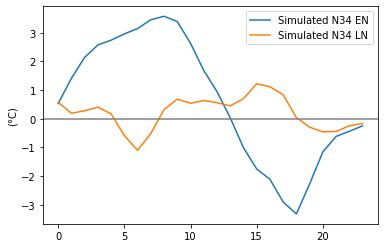

In [7]:
# idealised time series which is the same for all atmospheric variables (huss, tas, uas, vas, psl, rlds, rsds, prra, prsn, friver)
# plt.plot(xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/time_series/ts_mean_anoms_EN.nc').tas_10m, label='Idealised N34')

# simulated N34 index 
base = '/g/data/e14/mv7494/access-om2/archive/'; run = ['025deg_jra55_ryf_ENControl','025deg_jra55_ryf_ENFull','025deg_jra55_ryf_LNFull']
# select SSTs in the N34 region
N34_clim = xr.open_mfdataset(base+run[0]+'/output325/ocean/ocean.nc').temp[:,0,:,:].isel(yt_ocean=slice(477,519)).isel(xt_ocean=slice(359,640)).mean(['xt_ocean','yt_ocean']).values
N34      = xr.open_mfdataset(base+run[1]+'/output325/ocean/ocean.nc').temp[:,0,:,:].isel(yt_ocean=slice(477,519)).isel(xt_ocean=slice(359,640)).mean(['xt_ocean','yt_ocean']).values
plt.plot(N34 - N34_clim, label='Simulated N34 EN')

N34_clim = xr.open_mfdataset(base+run[0]+'/output325/ocean/ocean.nc').temp[:,0,:,:].isel(yt_ocean=slice(477,519)).isel(xt_ocean=slice(359,640)).mean(['xt_ocean','yt_ocean'])
N34_clim = np.repeat(N34_clim,2).values # repeat the clim time series twice as my LNFull simulation has a duration of four years

N34      = xr.open_mfdataset(base+run[2]+'/output32*/ocean/ocean.nc').temp[:,0,:,:].isel(yt_ocean=slice(477,519)).isel(xt_ocean=slice(359,640)).mean(['xt_ocean','yt_ocean']).values
N34

plt.plot((N34 - N34_clim)[12:36], label='Simulated N34 LN')
plt.ylabel('(°C)'); plt.legend()
plt.axhline(0, c='grey')
# Walltime: 

### Show temperature anomalies during peak ENFull and LNFull simulations around Antarctica
- depth-integrated anomalies in the upper 1000 m
- contour line of the 1000 dbar isobath

In [8]:
# %%time
# base = '/g/data/e14/mv7494/access-om2/archive/'
# run = ['025deg_jra55_ryf_ENControl/','025deg_jra55_ryf_ENFull/', '025deg_jra55_ryf_LNFull/']
       
# temp_clim = xr.open_mfdataset(base+run[0]+'output325/ocean/ocean.nc').temp[11,:,:,:].isel(st_ocean=slice(0,29))
# for f in [1,2]:
#     temp = xr.open_mfdataset(base+run[f]+'output325/ocean/ocean.nc').temp[11,:,:,:].isel(st_ocean=slice(0,29))
#     anom = (temp - temp_clim).mean(['st_ocean']).isel(yt_ocean=slice(0,210)).load() # remove the control simulation
    
#     if f == 1: anomEN = anom
#     if f == 2: anomLN = anom
# plt.subplot(1,2,1); anomEN.plot(levels=np.linspace(-.5,.5,21))
# plt.subplot(1,2,2); anomLN.plot(levels=np.linspace(-.5,.5,21))
# # Wall time: 3.91 s

### Next, get the 1000 dbar isobath

In [9]:
topo = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/topog.nc').depth
field = xr.open_mfdataset(base+run[0]+'/output325/ocean/ocean.nc').temp[11,0,:,:]
field.values = topo.values # write topography data into [yt_ocean, xt_ocean] array structure

### Plotting routine

In [10]:
%%time
# ------------------------------------------------------------------------- #
# Hier Spezifikation für welche Tiefe ich Anomaliesn plotte                 #
depth = [0, 29]; tiefe = '1000m'   # plot for upper 1000 m (1.15-1029.9)    # 
# depth = [0, 18]; tiefe = '200m'    # plot for upper 200 m  (1.15-193.6 m) #
# ------------------------------------------------------------------------- #


import matplotlib.path as mpath 
import imageio
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = [.83,.83,.83], facecolor = [.83,.83,.83], zorder = 1)

    xlab =    [.99,          1,     .5,    -.01,      0, .55] # x-position of labels
    ylab =    [.76,        .22,   -.04,     .22,    .76, .775] # y-position of labels
    txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S'] # label text
    # loop through the 7 labels and surround with white space for higher visibility
    for l in range(len(txt_lab)):
        ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['025deg_jra55_ryf_ENControl/','025deg_jra55_ryf_ENFull/', '025deg_jra55_ryf_LNFull/']

writer = animation.writers['ffmpeg'](fps = 0.2)

# initialise figure
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1, 2, width_ratios = [1,1]) 
        
# Create the function that updates the figure. I need ax.clear() to update the plot, but this also clears Cartopy features, so sadly we have to redraw this in every step
# ------------------------------------------------------------------ #
with writer.saving(fig, '/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_'+tiefe+'.mp4', dpi=300):      
    for i in range(6,18): # loop through months and create a movie
        filename = '/home/561/mv7494/ENSOAnt_figures/ENFull_and_LNFull_temp_anoms_month'+f'{i+1}.png' 
        print('Creating figure for month '+ str(i+1))
        if os.path.isfile('/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_'+tiefe+'.mp4') == True: # skip iteration if final movie already exists
            continue 
        ax1.clear()
        temp_clim = xr.open_mfdataset(base+run[0]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))       
        
        for exp in [1,2]: # loop through ENFull and LNFull simulation
            if exp == 1:
                temp = xr.open_mfdataset(base+run[exp]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))
            if exp == 2:
                temp = xr.open_mfdataset(base+run[exp]+'output32*/ocean/ocean.nc').temp[i+12,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))
            anom = (temp - temp_clim).mean(['st_ocean']).isel(yt_ocean=slice(0,210)).load() # remove the control simulation

            if exp == 1: anomEN = anom
            if exp == 2: anomLN = anom
            # Walltime: 17.3 s
            
        # ------------------------------------------------------------------------------------------------------------------------------------ #
        # figure here
        # ------------------------------------------------------------------------------------------------------------------------------------ #
        # adjust the colour bar for the single EN events (bigger magnitude of anomalies as the regression maps represent a single event)
        tos_ticks = np.linspace(-.5,.5,21); skala = 30; niveau = [1000] 

        for f in range(2): # loop through each subplot
            if f == 0:  panel = gs[0,0]; map = anomEN;  ticks = tos_ticks 
            if f == 1:  panel = gs[0,1]; map = anomLN;  ticks = tos_ticks    

            titles = ['El Niño Full', 'La Niña Full']
            ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))

            ax1.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
            fancy_plot(ax1)

            p1 = map.plot.contourf(ax=ax1, cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
            p11 = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())

            # 1000 dbar isobath
            p111 = field.plot.contour(levels = [1000], linewidths=1.25, cmap='k', transform=ccrs.PlateCarree())


            # Amundsen and Bellingshausen Sea regions
            AS = [-130,-100,-76,-60]
            plt.plot([AS[0], AS[0]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.plot([AS[1], AS[1]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.plot([AS[0], AS[1]], [AS[2], AS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.text(-115, -68, 'AS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
            BS = [-100,-80,-76,-60]
            plt.plot([BS[0], BS[0]], [BS[2], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.plot([BS[1], BS[1]], [BS[2], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.plot([BS[0], BS[1]], [BS[2], BS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
            plt.text(-90, -68, 'BS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])         

            ax1.text(-.01, .95,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

            plt.title(titles[f], fontsize=16) # title
            plt.suptitle('Month '+str(i+1), fontsize=16)

            cb = plt.colorbar(p1, shrink=.35, orientation='vertical') # add colour bar  
            cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator;cb.update_ticks()  
            cb.add_lines(p11) # add contours to colour bar
            # remove superfluous axis labels
            if f in [1,3]: ax1.set_yticklabels([]) # overwrite y-axis tick (i.e. longitude) labels
            if f in [0,1]: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        writer.grab_frame()
        if i in [12]:
            # --- saving as 300 dpi .PNG image in specified folder ------------------------ #
            plt.savefig(filename,                                                           # 
                        dpi=300, facecolor='w',                                             #
                        edgecolor='w', orientation='landscape', papertype=None,             #
                        format=None, transparent=False, bbox_inches=None,                   #
                        pad_inches=0.1, metadata=None);                                     #
            # if i !=11: plt.close() # do not show the plots, except for the peak of event  #
            # --- end of script ----------------------------------------------------------- # 
        
    print('--------------------')
    print('Figures all done.')
# Wall time: 28 mins 18s

Creating figure for month 7
Creating figure for month 8
Creating figure for month 9
Creating figure for month 10
Creating figure for month 11
Creating figure for month 12
Creating figure for month 13
Creating figure for month 14
Creating figure for month 15
Creating figure for month 16
Creating figure for month 17
Creating figure for month 18
--------------------
Figures all done.
CPU times: user 308 ms, sys: 184 ms, total: 492 ms
Wall time: 2.98 s


<Figure size 1152x648 with 0 Axes>

### Next, depth vs. latitude plots of the temperature anomalies across different transects
- Import climatological isotherm depths

In [11]:
%%time
base_rmh = '/g/data/ik11/outputs/access-om2-025/025deg_jra55_ryf9091_gadi/output'
# ----------------------------------------------------------------------------- #
nr_outputs = 15    # define number of output files to consider
last_output = 324  # the last output to consider loading in
# ----------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
for i in s: # loop through the number of files I would like
    c.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    c[i] = base_rmh+str(a[i]).zfill(3) + '/ocean/ocean.nc' 
    
# load in data set ------------------------------------------------------------ #
temp = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp.isel(st_ocean=slice(0,27)).isel(yt_ocean=slice(0,210)).mean(['time'])
# climatological temperature in the upper 782.1 m south of 60°S

clim_iso_A = temp.isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(599,680)).mean(['xt_ocean']).load() - 273.15 # mean in the Amundsen Sea sector -> load in and convert to °C
clim_iso_B = temp.isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(719,800)).mean(['xt_ocean']).load() - 273.15 # mean in the Bellingshausen Sea sector

CPU times: user 8.58 s, sys: 1.56 s, total: 10.1 s
Wall time: 28.2 s


In [12]:
%%time
def fancy_plot2(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 
    axes_nr.set_ylim([510,0]) # set plot limits
    axes_nr.set_xlim([-75,-70])

    axes_nr.set_xticks([-75,-74,-72,-70])
    axes_nr.set_yticks([500,400,300,200,100, 0])

    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lat_formatter) # "       "       "
    
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    plt.ylabel('Depth (m)', fontsize=16)
    axes_nr.set_facecolor([.83,.83,.83]) # set shelf region to grey colour
    
# ------------------------------------------------------------------ #
base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['025deg_jra55_ryf_ENControl/','025deg_jra55_ryf_ENFull/', '025deg_jra55_ryf_LNFull/']

# initialise figure
fig = plt.figure(figsize=(12, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios = [1,1]) 

writer = animation.writers['ffmpeg'](fps = 0.2)

with writer.saving(fig, '/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_depth.mp4', dpi=300):      
    for i in range(24):
        filename = '/home/561/mv7494/ENSOAnt_figures/ENFull_and_LNFull_temp_anoms_depth'+f'{i+1}.png' 
        print('Creating figure for month '+ str(i+1))
        if os.path.isfile('/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_depth.mp4') == True: # skip iteration if final movie already exists
            continue 
        ax1.clear() 

        for f in [1,2]:
            temp_clim = xr.open_mfdataset(base+run[0]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(0,27)) # upper 700 m
            if f == 1:
                temp = xr.open_mfdataset(base+run[f]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(0,27))
            if f == 2:
                temp = xr.open_mfdataset(base+run[f]+'output32*/ocean/ocean.nc').temp[i+12,:,:,:].isel(st_ocean=slice(0,27))
                                                      # Amundsen sector: 130°E - 110°E (599,680)
            anom_A = (temp - temp_clim).isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(599,680)).mean(['xt_ocean']) # remove the control simulation
                                                      # Bellingshausen sector: 100°E - 80°E (599,680)
            anom_B = (temp - temp_clim).isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(719,800)).mean(['xt_ocean']) # remove the control simulation

            if f == 1: anom_A_EN = anom_A; anom_B_EN = anom_B
            if f == 2: anom_A_LN = anom_A; anom_B_LN = anom_B

        for f in range(4):
            if f == 0: 
                panel = gs[0,0]; anom = anom_A_EN; iso = clim_iso_A
                titles = 'Amundsen sector: El Niño Full'
            if f == 1: 
                panel = gs[0,1]; anom = anom_A_LN; iso = clim_iso_A
                titles = 'Amundsen sector: La Niña Full'
            if f == 2: 
                panel = gs[1,0]; anom = anom_B_EN; iso = clim_iso_B
                titles = 'Bellingshausen sector: El Niño Full'
            if f == 3: 
                panel = gs[1,1]; anom = anom_B_LN; iso = clim_iso_B 
                titles = 'Bellingshausen sector: La Niña Full'

            ax1 = plt.subplot(panel)

            ticks = np.linspace(-.4,.4,num=21) # ticks for colour bar

            p1 = anom.plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')
            # p11 = anom.plot.contour(levels = [0], linewidths=.25, cmap='grey')

            p22 = iso.plot.contour(levels = np.linspace(-3,3,21),linewidths=1.0, colors='grey',interpolation='none')
            plt.clabel(p22, inline_spacing=1, fontsize=16)

            plt.title(titles, fontsize=16) # title
            fancy_plot2(ax1)
            ax1.text(0, 1.05,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # subplot label
            if f in [1,3]:
                ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False) # suppress x-axis ticks & labels 
            if f in [0,1]:
                ax1.set_xticklabels([]); ax1.xaxis.label.set_visible(False) # suppress x-axis ticks & labels 


            position1 = [.98, .32, 0.0125, 0.32]; # position2 = [.61, 0, 0.32, 0.0125] # x0, y0, width, height
            # add colour bar 1  
            cax = fig.add_axes(position1) # position: [x0, y0, width, height]
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
            cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()

            # # add colour bar 2
            # cax = fig.add_axes(position2) # position: [x0, y0, width, height]
            # cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            # cb.set_label(label='(10$^{12}$ J m$^{-2}$ year$^{-1}$)', size=16)
            # cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            # cb.locator = tick_locator;cb.update_ticks()
            # cb.add_lines(p11) # add contours to colour bar 

            plt.suptitle('Month '+str(i+1), fontsize=16)

            if i in [12]:
                # --- saving as 300 dpi .PNG image in specified folder ------------------------ #
                plt.savefig(filename,                                                           # 
                            dpi=300, facecolor='w',                                             #
                            edgecolor='w', orientation='landscape', papertype=None,             #
                            format=None, transparent=False, bbox_inches=None,                   #
                            pad_inches=0.1, metadata=None);                                     #
                # if i !=11: plt.close() # do not show the plots, except for the peak of event  #
                # --- end of script ----------------------------------------------------------- # 
        writer.grab_frame()
print('--------------------')
print('Figures all done.')

# CPU times: user 7min 53s, sys: 29.8 s, total: 8min 23s
# Wall time: 10min 59s
# Walltime: 2min 46s

Creating figure for month 1
Creating figure for month 2
Creating figure for month 3
Creating figure for month 4
Creating figure for month 5
Creating figure for month 6
Creating figure for month 7
Creating figure for month 8
Creating figure for month 9
Creating figure for month 10
Creating figure for month 11
Creating figure for month 12
Creating figure for month 13
Creating figure for month 14
Creating figure for month 15
Creating figure for month 16
Creating figure for month 17
Creating figure for month 18
Creating figure for month 19
Creating figure for month 20
Creating figure for month 21
Creating figure for month 22
Creating figure for month 23
Creating figure for month 24
--------------------
Figures all done.
CPU times: user 43.9 ms, sys: 20.1 ms, total: 64.1 ms
Wall time: 146 ms


<Figure size 864x648 with 0 Axes>

### Plotting routine for zoom of spatial maps

Creating figure for month 2
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 3
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 4
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 5
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 6
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 7
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 8
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 9
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 10
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 11
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 12
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 13
025deg_jra55_ryf_ENFull/
025deg_jra55_ryf_LNFull/
Creating figure for month 14
025deg_jra55_ryf_ENFull/
025deg

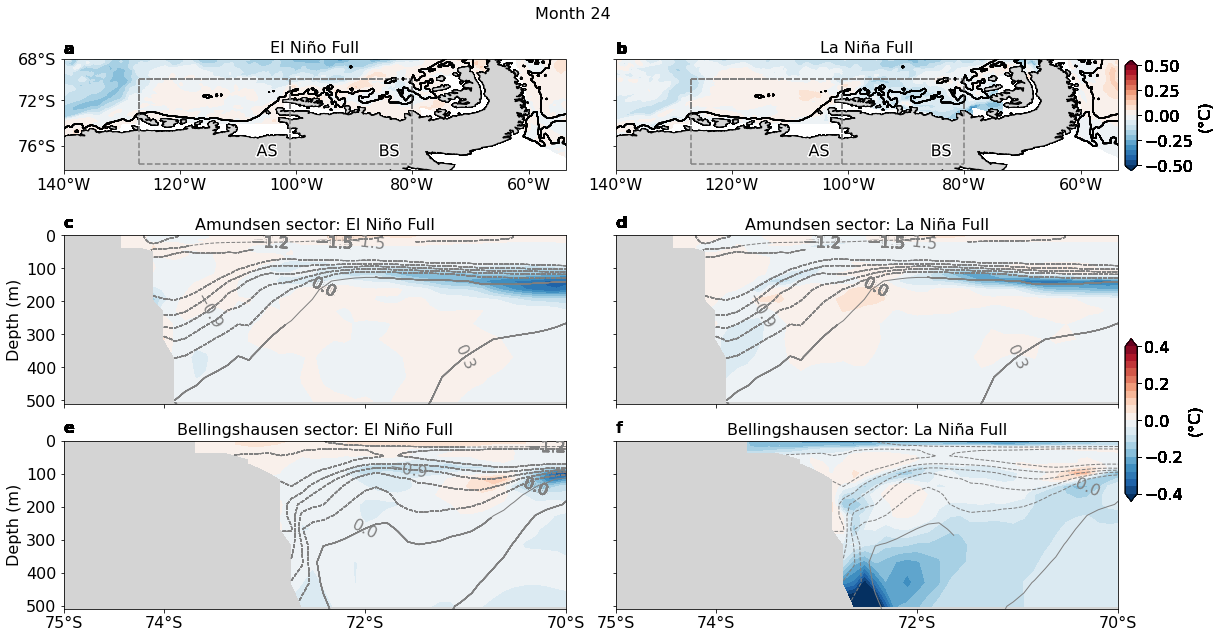

In [13]:
%%time

def fancy_plot(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([-140,-120,-100,-80, -60], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-76, -72, -68], crs=ccrs.PlateCarree())
    #axes_nr.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    #axes_nr.grid(linewidth=.5, color='grey', alpha=0.5) # grid specifics
    #axes_nr.xaxis.label.set_visible(False) # only labels on left & bottom
    #axes_nr.yaxis.label.set_visible(False)
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)

    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    # Amundsen and Bellingshausen Sea regions
    AS = [-127,-101,-77.5,-70]
    plt.plot([AS[0], AS[0]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # West line
    plt.plot([AS[1], AS[1]], [AS[2], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # East line
    plt.plot([AS[0], AS[1]], [AS[2], AS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # South line
    plt.plot([AS[0], AS[1]], [AS[3], AS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),) # North line of rectangle
    plt.text(-105, -76.5, 'AS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
    BS = [-101,-80,-77.5,-70]
    plt.plot([BS[1], BS[1]], [BS[2], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.plot([BS[0], BS[1]], [BS[2], BS[2]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.plot([BS[0], BS[1]], [BS[3], BS[3]],color='gray', linestyle='--',transform=ccrs.PlateCarree(),)
    plt.text(-84, -76.5, 'BS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])         

def fancy_plot2(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 
    axes_nr.set_ylim([510,0]) # set plot limits
    axes_nr.set_xlim([-75,-70])

    axes_nr.set_xticks([-75,-74,-72,-70])
    axes_nr.set_yticks([500,400,300,200,100, 0])

    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lat_formatter) # "       "       "
    
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    plt.ylabel('Depth (m)', fontsize=16)
    axes_nr.set_facecolor([.83,.83,.83]) # set shelf region to grey colour
# -------------------------------------------------------------------------------- #
# Hier Spezifikation für welche Tiefe ich Anomaliesn plotte                        #
# depth = [0, 29]; tiefe = '1000'   # plot for upper 1000 m (1.15-1029.9)         # 
depth = [0, 24]; tiefe = ['500', 500]      # plot for upper 500 m (1.15-1029.9)   # 
# depth = [0, 18]; tiefe = '200'    # plot for upper 200 m  (1.15-193.6 m)        #
# -------------------------------------------------------------------------------- #


base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['025deg_jra55_ryf_ENControl/','025deg_jra55_ryf_ENFull/', '025deg_jra55_ryf_LNFull/']

writer = animation.writers['ffmpeg'](fps = 0.2)

# initialise figure
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 2) 

# Create the function that updates the figure. I need ax.clear() to update the plot, but this also clears Cartopy features, so sadly we have to redraw this in every step
# ------------------------------------------------------------------ #
with writer.saving(fig, '/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_'+tiefe[0]+'m_zoom.mp4', dpi=300):      
    for i in range(1,24): # loop through months and create a movie
        filename = '/home/561/mv7494/ENSOAnt_figures/ENFull_and_LNFull_temp_anoms_month'+f'{i+1}.png' 
        print('Creating figure for month '+ str(i+1))
        # if os.path.isfile('/g/data/e14/mv7494/ENFull_and_LNFull_temp_anoms_'+tiefe[0]+'m_zoom.mp4') == True: # skip iteration if final movie already exists
        #     continue 
        ax1.clear()
        # data for spatial maps
        temp_clim = xr.open_mfdataset(base+run[0]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))
        # data for depth-latitude panels
        temp_clim2 = xr.open_mfdataset(base+run[0]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(0,27)) # upper 700 m

        for exp in [1,2]: # loop through ENFull and LNFull simulation
            if exp == 1:
                print(run[exp])
                temp = xr.open_mfdataset(base+run[exp]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))
                temp2 = xr.open_mfdataset(base+run[exp]+'output325/ocean/ocean.nc').temp[i,:,:,:].isel(st_ocean=slice(0,27))
            if exp == 2:
                print(run[exp])
                temp = xr.open_mfdataset(base+run[exp]+'output32*/ocean/ocean.nc').temp[i+12,:,:,:].isel(st_ocean=slice(depth[0],depth[1]))
                temp2 = xr.open_mfdataset(base+run[exp]+'output32*/ocean/ocean.nc').temp[i+12,:,:,:].isel(st_ocean=slice(0,27))

            anom = (temp - temp_clim).mean(['st_ocean']).isel(yt_ocean=slice(0,210)).load() # remove the control simulation
            # Amundsen sector: 130°E - 110°E (599,680)
            anom_A = (temp - temp_clim).isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(599,680)).mean(['xt_ocean']) # remove the control simulation
            # Bellingshausen sector: 100°E - 80°E (599,680)
            anom_B = (temp - temp_clim).isel(yt_ocean=slice(0,210)).isel(xt_ocean=slice(719,800)).mean(['xt_ocean']) # remove the control simulation

            if exp == 1: anomEN = anom; anom_A_EN = anom_A; anom_B_EN = anom_B
            if exp == 2: anomLN = anom; anom_A_LN = anom_A; anom_B_LN = anom_B
            # Walltime: 17.3 s          

        # ------------------------------------------------------------------------------------------------------------------------------------ #
        # figure here
        # ------------------------------------------------------------------------------------------------------------------------------------ #
        # adjust the colour bar for the single EN events (bigger magnitude of anomalies as the regression maps represent a single event)
        ticks = np.linspace(-.5,.5,21); skala = 30; niveau = [1000] 

        for f in range(6): # loop through each subplot
            if f == 0: panel = gs[0,0]; map = anomEN;  ticks = np.linspace(-.5,.5,21)
            if f == 1: panel = gs[0,1]; map = anomLN;  ticks = np.linspace(-.5,.5,21)  
            if f == 2: panel = gs[1,0]; anom = anom_A_EN; iso = clim_iso_A; titles = 'Amundsen sector: El Niño Full'
            if f == 3: panel = gs[1,1]; anom = anom_A_LN; iso = clim_iso_A; titles = 'Amundsen sector: La Niña Full'
            if f == 4: panel = gs[2,0]; anom = anom_B_EN; iso = clim_iso_B; titles = 'Bellingshausen sector: El Niño Full'
            if f == 5: panel = gs[2,1]; anom = anom_B_LN; iso = clim_iso_B; titles = 'Bellingshausen sector: La Niña Full'

    # here the spatial map panels
    # ------------------------------------------------------------------------------------------------------------------------------------ #        
            if f in [0,1]:
                titles = ['El Niño Full', 'La Niña Full']
                ax1 = plt.subplot(panel, projection=ccrs.Miller(central_longitude=200))

                ax1.set_extent([-140, -53.5, -78, -68], crs=ccrs.PlateCarree())
                fancy_plot(ax1)

                p1 = map.plot.contourf(ax=ax1, cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
                # p11 = map.plot.contour(ax=ax1, levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())

                # 1000 dbar isobath
                p111 = field.plot.contour(levels = [tiefe[1]], linewidths=1.25, cmap='k', transform=ccrs.PlateCarree())

                plt.title(titles[f], fontsize=16) # title
                plt.suptitle('Month '+str(i+1) + ' '+tiefe[0]+' m', fontsize=16)

                if f == 1: ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False) # suppress x-axis ticks & labels 
                ax1.text(0, 1.05,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # subplot label
                

    # here the depth-latitude panels
    # ------------------------------------------------------------------------------------------------------------------------------------ #
            if f >= 2:
                ax1 = plt.subplot(panel)

                ticks = np.linspace(-.4,.4,num=21) # ticks for colour bar

                p2 = anom.plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')

                p22 = iso.plot.contour(levels = np.linspace(-3,3,21),linewidths=1.0, colors='grey',interpolation='none')
                plt.clabel(p22, inline_spacing=1, fontsize=16)

                plt.title(titles, fontsize=16) # title
                fancy_plot2(ax1)
                ax1.text(0, 1.05,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # subplot label
                if f in [3,5]:
                    ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False) # suppress x-axis ticks & labels 
                if f in [2,3]:
                    ax1.set_xticklabels([]); ax1.xaxis.label.set_visible(False) # suppress x-axis ticks & labels 

                plt.suptitle('Month '+str(i+1), fontsize=16)

        # colour bar for the depth-latitude panels
        position1 = [.98, .727, 0.01, 0.17]; position2 = [.98, .217, 0.01, 0.25] # x0, y0, width, height
        # add colour bar 1  
        cax = fig.add_axes(position1) # position: [x0, y0, width, height]
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
        cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()
        # add colour bar 2 
        cax = fig.add_axes(position2) # position: [x0, y0, width, height]
        cb = plt.colorbar(p2, cax = cax, shrink=.5, orientation='vertical'); 
        cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()

        writer.grab_frame()
    if i in [12]:
        # --- saving as 300 dpi .PNG image in specified folder ------------------------ #
        plt.savefig(filename,                                                           # 
                    dpi=300, facecolor='w',                                             #
                    edgecolor='w', orientation='landscape', papertype=None,             #
                    format=None, transparent=False, bbox_inches=None,                   #
                    pad_inches=0.1, metadata=None);                                     #
        # if i !=11: plt.close() # do not show the plots, except for the peak of event  #
        # --- end of script ----------------------------------------------------------- # 
print('--------------------')
print('Figures all done.')
# Wall time: 11min 41s

### Code structure to create a gif - DO NOT DELETE

In [14]:
# for i in range(10,19): # loop through 12 months and create a gif
#     filename = '/home/561/mv7494/ENSOAnt_figures/ENWind_and_LNWind_temp_anoms_month'+f'{i+1}.png' 
#     filenames.append(filename) # create file name and append it to a list
#     if os.path.isfile(filename) == True and i!=11: # skip iteration if final .nc file already exists
#         continue  
#     print('Creating figure for month '+ str(i+1))

    # # initialise figure
    # fig = plt.figure(figsize=(12, 9),tight_layout=True,facecolor='w',edgecolor='k')
    # gs = gridspec.GridSpec(2, 2, width_ratios = [1,1]) 
    # p1 = (anom*ts[t]).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both') 

# # create the gif
# with imageio.get_writer('/home/561/mv7494/ENSOAnt_figures/'+'ENWind_and_LNWind_temp_anoms.gif', mode='I', duration=2) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
# # Wall time: 10min 59s

In [15]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #